In [357]:
import pandas as pd
import numpy as np
import scanpy as sc
import tifffile
from skimage.util import img_as_ubyte
from skimage.filters import threshold_triangle, threshold_otsu
import pickle

import matplotlib.pyplot as plt
from matplotlib import rc_context

import os

# Patch separation

## envi, patches

In [721]:
cd4_pos = cd4_pos = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_3d_pos_cd4.csv',index_col=0)
cd8_pos = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_3d_pos_cd8.csv',index_col=0)

In [860]:
cd4_df = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_df\cd8\034_4.csv',index_col=0)
patched_cd4_df = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\patched_cell_df\cd8\034_4.csv',index_col=0)
cd4_adata = sc.read_h5ad(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_adata\cd8\034_4.h5ad')

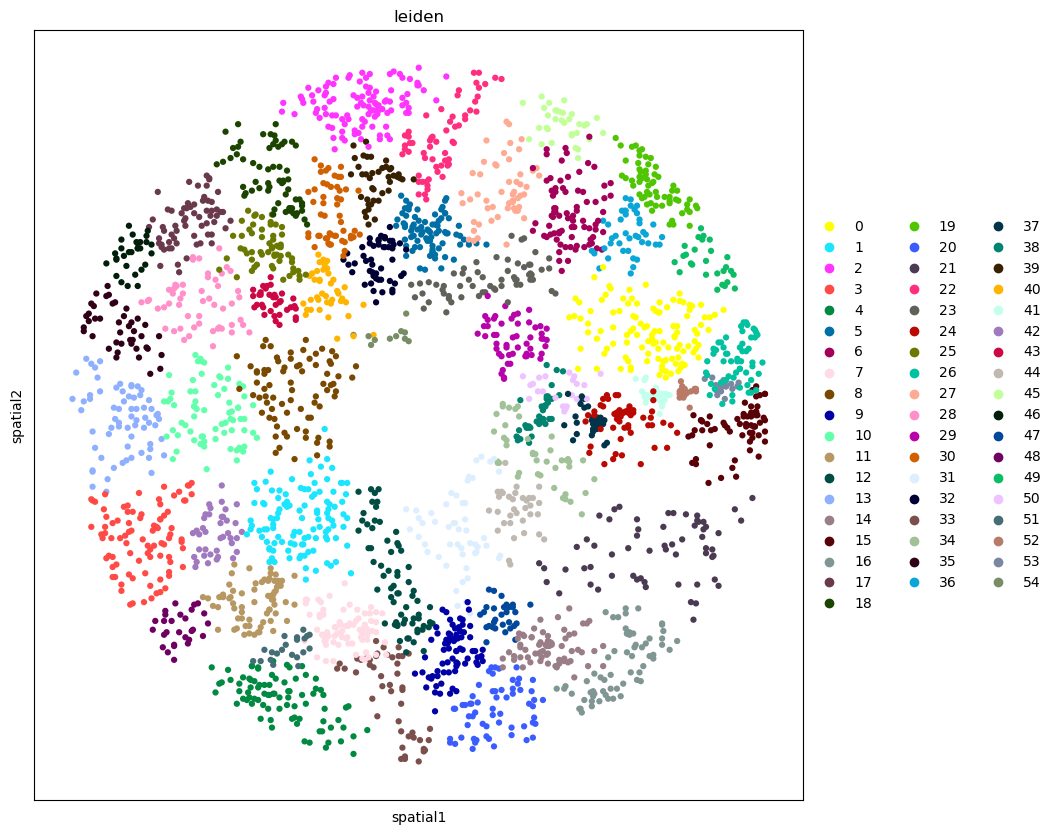

In [861]:
with rc_context({'figure.figsize':(10,10)}):
    sc.pl.spatial(cd4_adata,color=['leiden'],spot_size=5)

In [862]:
gene_sets = pd.read_pickle(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gene_set.pkl')

In [863]:
gene_name = []
for gene in cd4_df['gene'].tolist():
    temp = gene.split('_')[1]
    gene_name.append(gene_sets['set2'][temp])

cd4_df['gene_name'] = gene_name

In [864]:
genes = cd4_df['gene_name'].unique().tolist()
df_by_gene = cd4_df.groupby('gene_name')
color_l = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# set_colors = {}
# for i in range(len(genes)):
#     set2_colors[genes[i]] = color_l[i]

In [865]:
# with open('gene_set4_colors.pkl', 'wb') as f:
#     pickle.dump(set4_colors,f)

In [866]:
set1_colors = pd.read_pickle('gene_set1_colors.pkl')
set2_colors = pd.read_pickle('gene_set2_colors.pkl')
set3_colors = pd.read_pickle('gene_set3_colors.pkl')
set4_colors = pd.read_pickle('gene_set4_colors.pkl')

In [867]:
scale = 249.6/2304
z_scale = 0.3

In [868]:
def dapi_scatter(dapi_dir, cell, cell_pos):
    dapi = tifffile.imread(dapi_dir)
    cell_center = cell_pos[cell_pos['cellID']==cell].values.flatten()
    cell_center = cell_center[:3].astype('float')

    thre = threshold_otsu(dapi)
    dapi_scatter = np.where(dapi>0)
    dapi_df = pd.DataFrame({'row':list(dapi_scatter[0]), 'col':list(dapi_scatter[1]),'z':[25]*dapi_scatter[0].shape[0]})
    
    d = np.sqrt(np.sum((dapi_df.values - cell_center)**2, axis=1)) * scale
    dapi_df['dist'] = list(d)
    dapi_df = dapi_df[dapi_df['dist'] < 30]
    return dapi_df

In [869]:
dapi_df = dapi_scatter(r'..\..\coculture_diagonal\primed_pbmc\00_masks\all_cells\034_mask.tif', '034_4', cd8_pos)

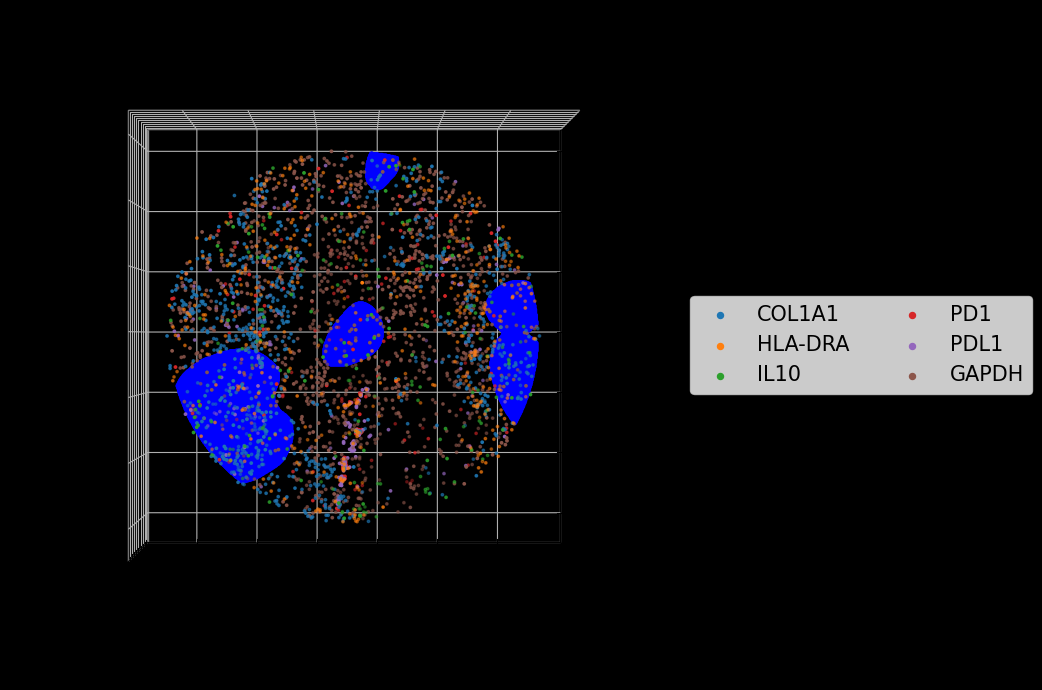

In [870]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(dapi_df['row']*scale,dapi_df['col']*scale,dapi_df['z']*z_scale,'.',color='b',s=1)
for i,g in enumerate(genes):
    sub_group = df_by_gene.get_group(g)
    c = set2_colors[g]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)
ax.view_init(90, 0)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
# plt.savefig(r'.\figures\cd4_013_3_scatter dots.png',dpi=300)

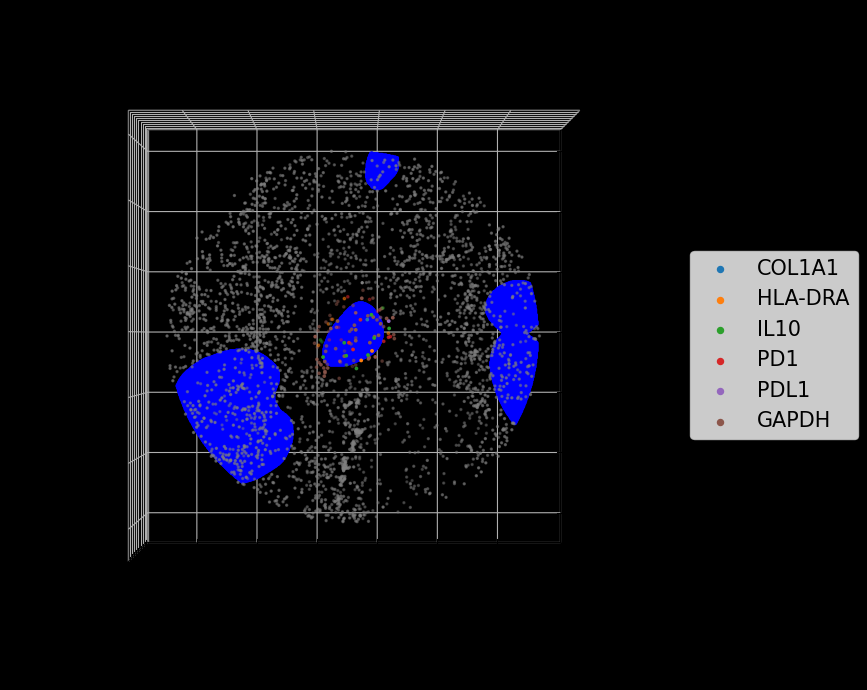

In [871]:
immune_df = cd4_df[cd4_df['in_immune']==True]
msc_df = cd4_df[cd4_df['in_immune']==False]
immune_by_gene = immune_df.groupby('gene_name')
msc_by_gene = msc_df.groupby('gene_name')

fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(dapi_df['row']*scale,dapi_df['col']*scale,dapi_df['z']*z_scale,'.',color='b',s=1)
ax.scatter(msc_df['row']*scale, msc_df['col']*scale,msc_df['z']*z_scale,'.',color='gray',s=2)
for i,g in enumerate(genes):
    if g in immune_df['gene_name'].tolist():
        sub_group = immune_by_gene.get_group(g)
        c = set2_colors[g]
        ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)
ax.view_init(90, 0)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=1,fontsize=15,markerscale=2.5)

plt.tight_layout()
# plt.savefig(r'.\figures\cd4_013_3_immune_scatter dots.png',dpi=300)

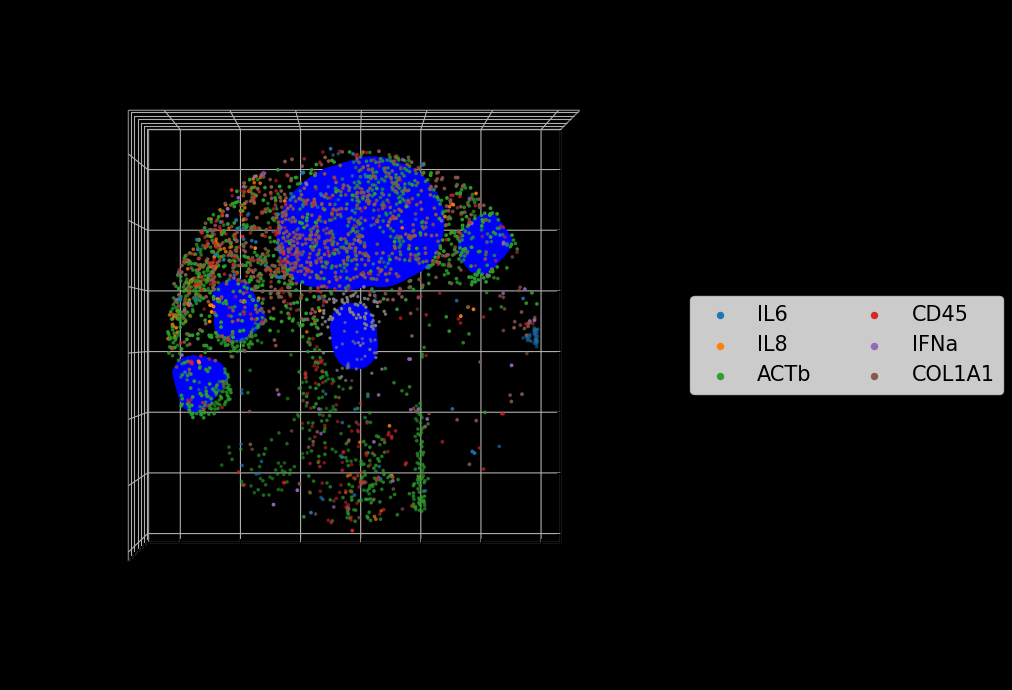

In [838]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(dapi_df['row']*scale,dapi_df['col']*scale,dapi_df['z']*z_scale,'.',color='b',s=1)
ax.scatter(immune_df['row']*scale, immune_df['col']*scale,immune_df['z']*z_scale,'.',color='gray',s=2)
for i,g in enumerate(genes):
    if g in msc_df['gene_name'].tolist():
        sub_group = msc_by_gene.get_group(g)
        c = set1_colors[g]
        ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)
ax.view_init(90, 00)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'.\figures\cd4_013_3_msc_scatter dots.png',dpi=300)

In [873]:
msc_by_patch = patched_cd4_df.groupby('leiden')
patches = patched_cd4_df['leiden'].unique().tolist()
patch_colors = cd4_adata.uns['leiden_colors']

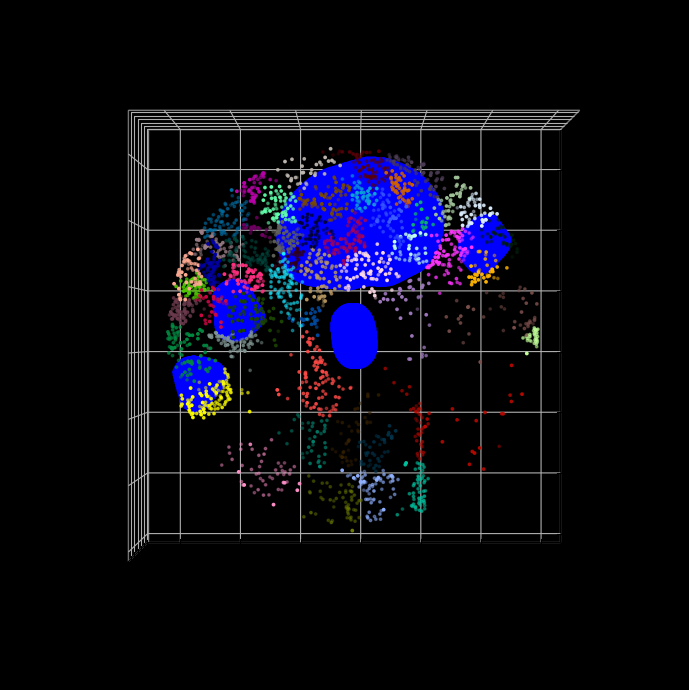

In [840]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(dapi_df['row']*scale,dapi_df['col']*scale,dapi_df['z']*z_scale,'.',color='b',s=1)
# ax.scatter(immune_df['row']*scale, immune_df['col']*scale,immune_df['z']*z_scale,'.',color='gray',s=2)
for i,p in enumerate(patches):
    sub_group = msc_by_patch.get_group(p)
    c = patch_colors[int(p)]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3)
ax.view_init(90, 0)
# ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'.\figures\cd4_013_3_msc_patch_scatter_dots.png',dpi=300)

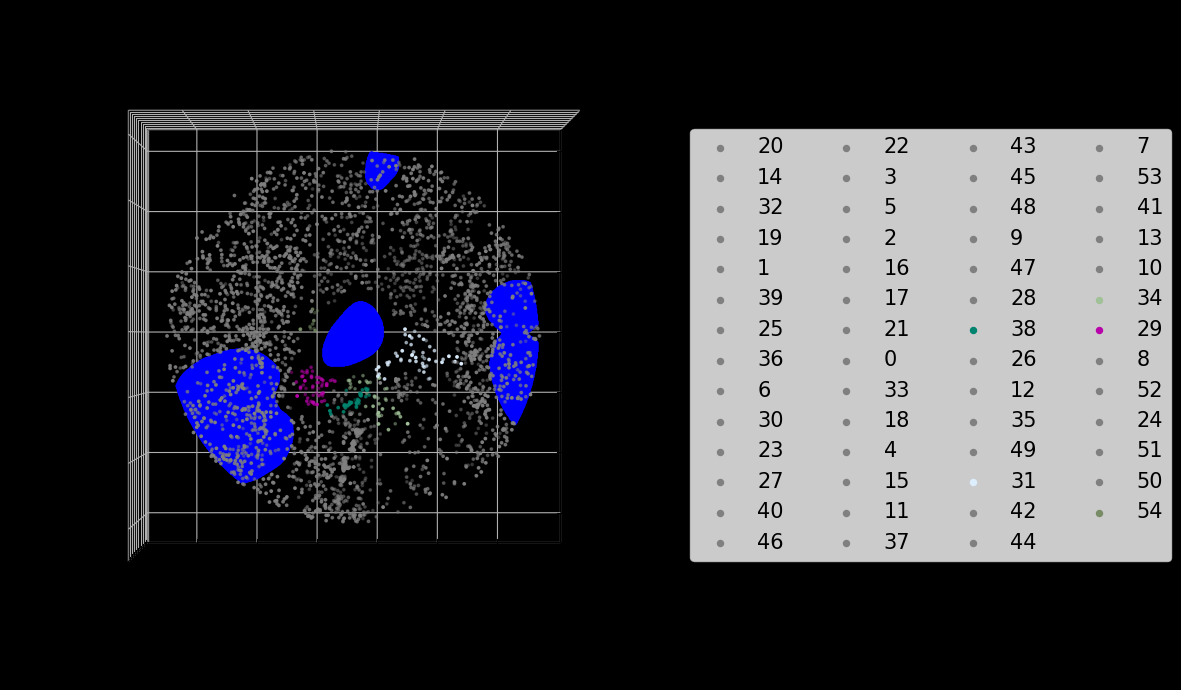

In [875]:
cd4_central_patches = [54, 38, 29, 31, 34]

fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(dapi_df['row']*scale,dapi_df['col']*scale,dapi_df['z']*z_scale,'.',color='b',s=1)
# ax.scatter(immune_df['row']*scale, immune_df['col']*scale,immune_df['z']*z_scale,'.',color='gray',s=2)
for i,p in enumerate(patches):
    sub_group = msc_by_patch.get_group(p)
    if p in cd4_central_patches:
        c = patch_colors[int(p)]
    else:
        c='gray'
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=p)
ax.view_init(90, 0)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=4,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'.\figures\cd8_034_4_msc_central_patch_scatter_dots.png',dpi=300)

In [844]:
import neighborhoodAnalysis as nha

In [845]:
# patch networks plot
patch_centers = patched_cd4_df.groupby('leiden').mean()
connected_pairs = nha.find_connected_pairs(patch_centers,5,'row','col','z')
coor = patch_centers.values[:,:3].astype('float')

In [846]:
(coor[:,2]*scale).shape

(50,)

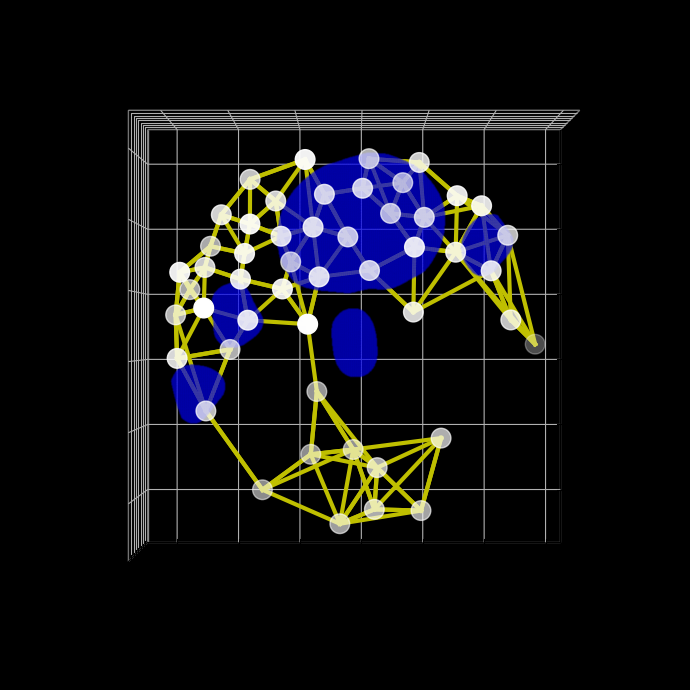

In [847]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(dapi_df['row']*scale,dapi_df['col']*scale,dapi_df['z']*z_scale,'.',color='b',s=0.5,alpha=0.1)
ax.scatter(list(coor[:,0]*scale),list(coor[:,1]*scale),list(coor[:,2]*z_scale),'.',color='w',s=200)
for p in connected_pairs:
    point1 = coor[p[0],:]
    point2 = coor[p[1],:]
    ax.plot([point1[0]*scale,point2[0]*scale],
            [point1[1]*scale,point2[1]*scale],
            [point1[2]*z_scale,point2[2]*z_scale],
            color='y',linewidth=3)
# ax.scatter(immune_df['row']*scale, immune_df['col']*scale,immune_df['z']*z_scale,'.',color='gray',s=2)

ax.view_init(90, 0)
# ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=4,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'.\figures\cd4_013_3_msc_patch_networks.png',dpi=300)

In [134]:
cd8_df = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_df\cd8\008_2.csv',index_col=0)
patched_cd8_df = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\patched_cell_df\cd8\008_2.csv',index_col=0)
cd8_adata = sc.read_h5ad(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_adata\cd8\008_2.h5ad')

In [135]:
# Change gene names
genes = pd.read_pickle(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gene_set.pkl')
def gene_list(cell_df,gene_map):
    genes = cell_df['gene'].tolist()
    fov_l = [int(item.split('_')[0]) for item in genes]
    gene_idx = [item.split('_')[-1] for item in genes]
    gene_name = []
    for i in range(len(genes)):
        set = 'set1'
        if fov_l[i] < 30:
            set = 'set1'
        elif fov_l[i] < 60:
            set = 'set2'
        elif fov_l[i] < 90:
            set = 'set3'
        else:
            set = 'set4'
        gene_name.append(gene_map[set][gene_idx[i]])
    return gene_name

In [136]:
cd8_df['gene_name'] = gene_list(cd8_df,genes)

In [137]:
patched_cd8_df['gene_name'] = gene_list(patched_cd8_df,genes)

In [141]:
cd4_by_gene = cd4_df.groupby('gene_name')
cd4_immune = cd4_df[cd4_df['in_immune']==True]
cd4_msc = cd4_df[cd4_df['in_immune']==False]
cd4_immune_by_gene = cd4_immune.groupby('gene_name')
cd4_msc_by_gene = cd4_msc.groupby('gene_name')
cd4_by_patch = patched_cd4_df.groupby('leiden')

cd8_by_gene = cd8_df.groupby('gene_name')
cd8_immune = cd8_df[cd8_df['in_immune']==True]
cd8_msc = cd8_df[cd8_df['in_immune']==False]
cd8_immune_by_gene = cd8_immune.groupby('gene_name')
cd8_msc_by_gene = cd8_msc.groupby('gene_name')
cd8_by_patch = patched_cd8_df.groupby('leiden')

genes = cd4_df['gene_name'].unique().tolist()

In [144]:
cd4_dapi = dapi_scatter(r'..\..\coculture_diagonal\primed_pbmc\00_masks\all_cells\008_mask.tif', '008_3', cd4_pos)
cd8_dapi = dapi_scatter(r'..\..\coculture_diagonal\primed_pbmc\00_masks\all_cells\008_mask.tif', '008_2', cd8_pos)

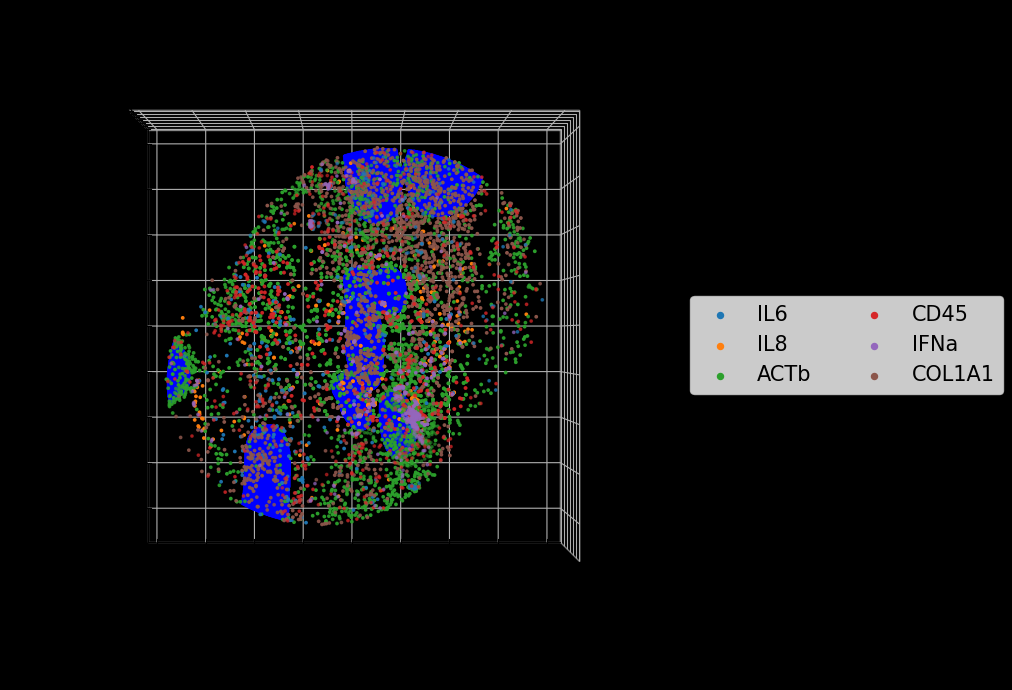

In [128]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(cd4_dapi['row']*scale,cd4_dapi['col']*scale,cd4_dapi['z']*z_scale,'.',color='b',s=1)
ax.scatter(cd8_dapi['row']*scale,cd8_dapi['col']*scale,cd8_dapi['z']*z_scale,'.',color='b',s=1)
# ax.scatter(immune_df['row']*scale, immune_df['col']*scale,immune_df['z']*z_scale,'.',color='gray',s=2)
genes = cd4_df['gene_name'].unique().tolist()
for i,g in enumerate(genes):
    sub_group = cd4_by_gene.get_group(g)
    c = set1_colors[g]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3)

genes = cd8_df['gene_name'].unique().tolist()
for i,g in enumerate(genes):
    sub_group = cd8_by_gene.get_group(g)
    c = set1_colors[g]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)

ax.view_init(90, 90)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'.\figures\cd4_008_3 cd8_003_1 scatter_dots.png',dpi=300)

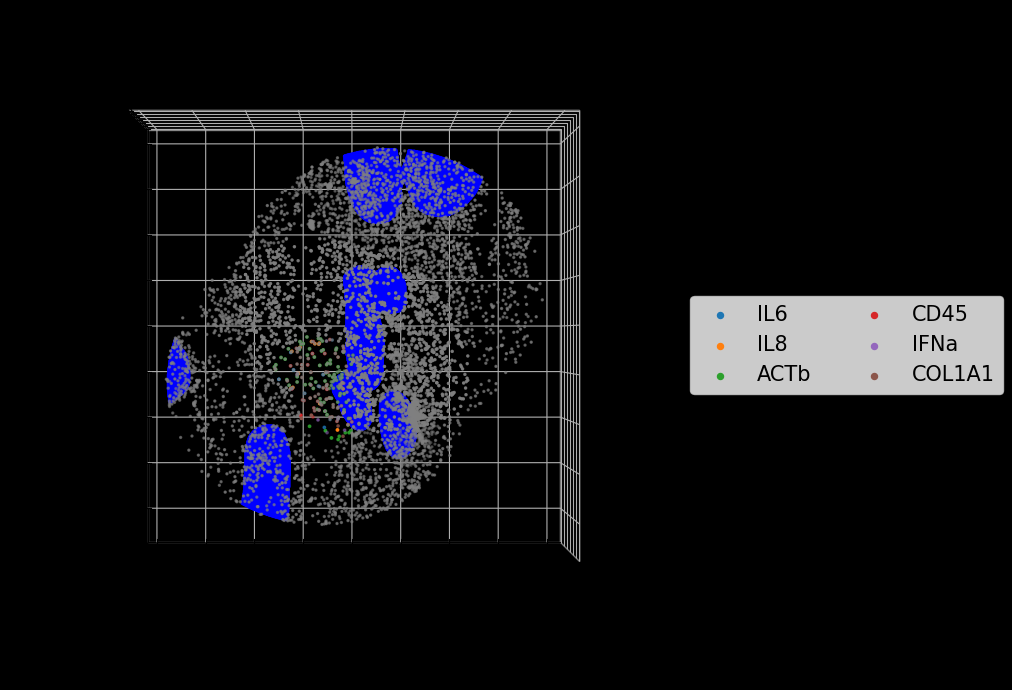

In [129]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(cd4_dapi['row']*scale,cd4_dapi['col']*scale,cd4_dapi['z']*z_scale,'.',color='b',s=1)
ax.scatter(cd8_dapi['row']*scale,cd8_dapi['col']*scale,cd8_dapi['z']*z_scale,'.',color='b',s=1)
ax.scatter(cd4_df['row']*scale, cd4_df['col']*scale,cd4_df['z']*z_scale,'.',color='gray',s=2)
ax.scatter(cd8_msc['row']*scale,cd8_msc['col']*scale,cd8_msc['z']*z_scale,color='gray',s=2)

genes = cd8_immune['gene_name'].unique().tolist()
for i,g in enumerate(genes):
    sub_group = cd8_immune_by_gene.get_group(g)
    c = set1_colors[g]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)

ax.view_init(90, 90)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'.\figures\cd4_008_3 cd8_003_1 immune scatter_dots.png',dpi=300)

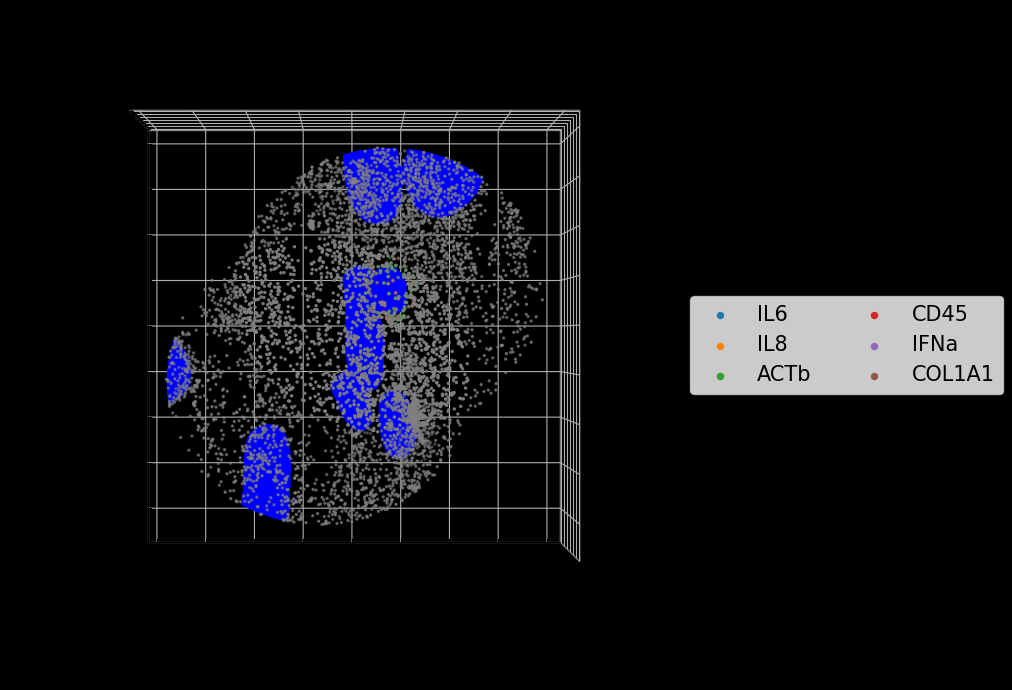

In [131]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(cd4_dapi['row']*scale,cd4_dapi['col']*scale,cd4_dapi['z']*z_scale,'.',color='b',s=1)
ax.scatter(cd8_dapi['row']*scale,cd8_dapi['col']*scale,cd8_dapi['z']*z_scale,'.',color='b',s=1)
ax.scatter(cd4_msc['row']*scale, cd4_msc['col']*scale,cd4_msc['z']*z_scale,'.',color='gray',s=2)
ax.scatter(cd8_df['row']*scale,cd8_df['col']*scale,cd8_df['z']*z_scale,color='gray',s=2)

genes = cd4_immune['gene_name'].unique().tolist()
for i,g in enumerate(genes):
    sub_group = cd4_immune_by_gene.get_group(g)
    c = set1_colors[g]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)

ax.view_init(90, 90)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'.\figures\cd4_008_3 immune cd8_003_1 scatter_dots.png',dpi=300)

## set2

## set3

## set 4

# cd8_cell plots

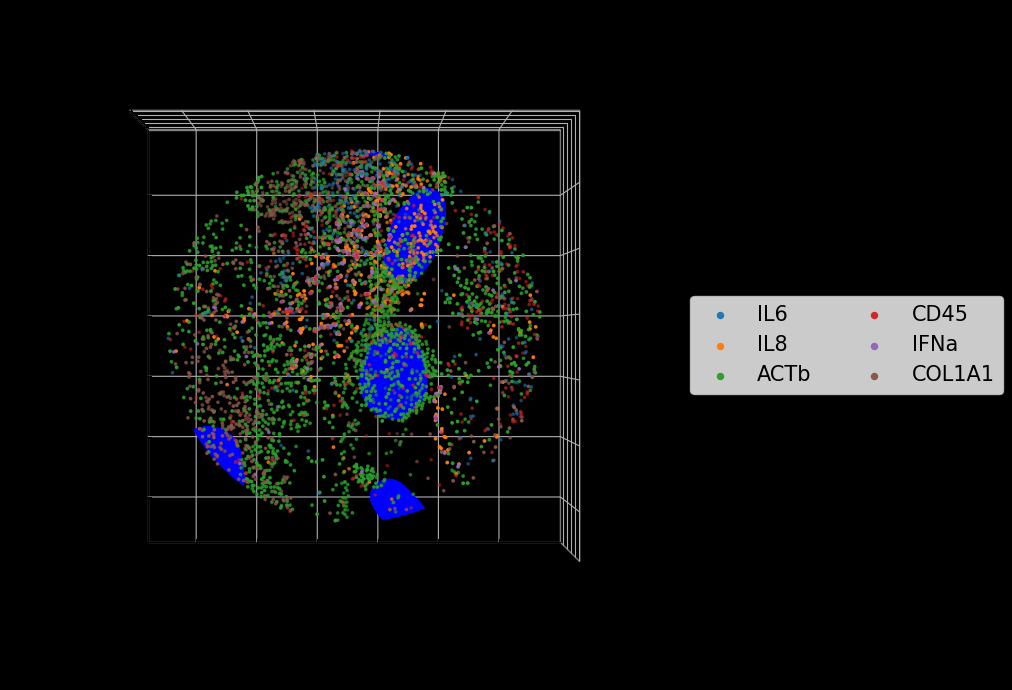

In [145]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(cd8_dapi['row']*scale,cd8_dapi['col']*scale,cd8_dapi['z']*z_scale,'.',color='b',s=1)
for i,g in enumerate(genes):
    sub_group = cd8_by_gene.get_group(g)
    c = set1_colors[g]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)
ax.view_init(90, 90)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'.\figures\cd8_008_2_scatter dots.png',dpi=300)

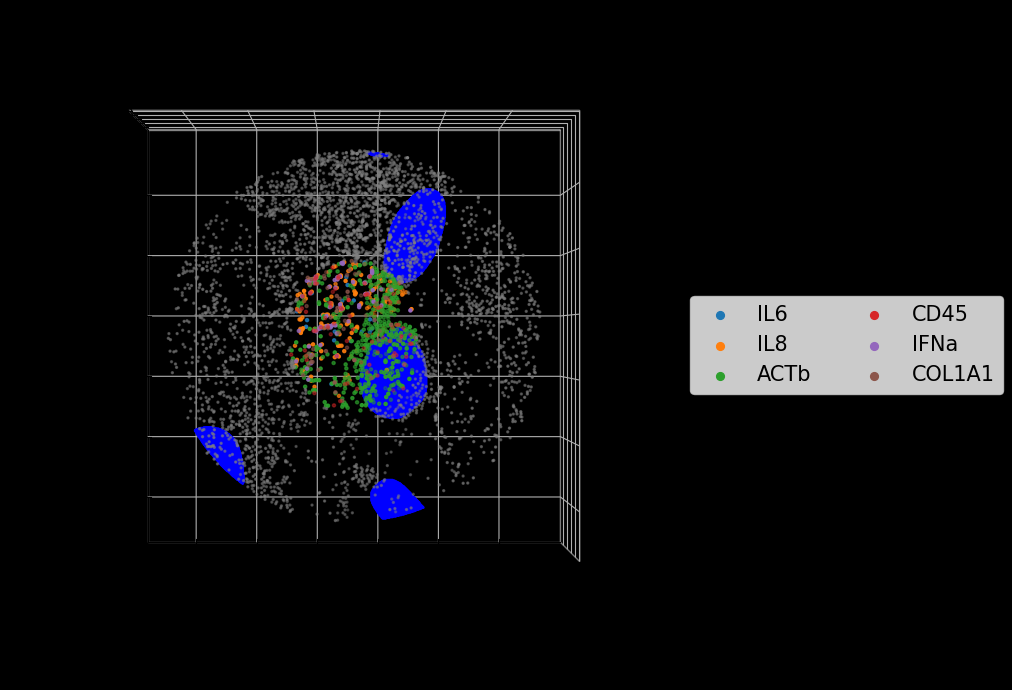

In [146]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(cd8_dapi['row']*scale,cd8_dapi['col']*scale,cd8_dapi['z']*z_scale,'.',color='b',s=1)
ax.scatter(cd8_msc['row']*scale, cd8_msc['col']*scale,cd8_msc['z']*z_scale,'.',color='gray',s=2)
for i,g in enumerate(genes):
    if g in cd8_immune['gene_name'].tolist():
        sub_group = cd8_immune_by_gene.get_group(g)
        c = set1_colors[g]
        ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=5,label=g)
ax.view_init(90, 90)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'.\figures\cd8_008_2_immune_scatter dots.png',dpi=300)

# combined patches

In [57]:
ref_fov = '008'
df_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_df\cd4'
df_l = os.listdir(df_dir)
df_l.sort()

cd4_dfs = []
for item in df_l:
    fov = item.split('_')[0]
    if fov == '008':
        cd4_dfs.append(pd.read_csv(os.path.join(df_dir,item),index_col=0))

df_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\patched_cell_df\cd8'
df_l = os.listdir(df_dir)
df_l.sort()

cd8_dfs = []
for item in df_l:
    fov = item.split('_')[0]
    if fov == '008':
        cd8_dfs.append(pd.read_csv(os.path.join(df_dir,item),index_col=0))
cd4_dfs = pd.concat(cd4_dfs)
cd8_dfs = pd.concat(cd8_dfs)

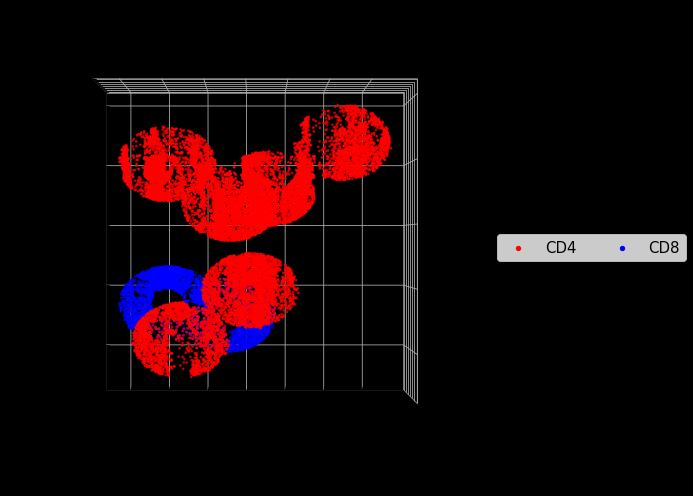

In [58]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(cd4_dfs['row']*scale,cd4_dfs['col']*scale,cd4_dfs['z']*z_scale,'.',color='r',s=3,label='CD4')
ax.scatter(cd8_dfs['row']*scale,cd8_dfs['col']*scale,cd8_dfs['z']*z_scale,'.',color='b',s=3,label='CD8')
ax.view_init(90, 90)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
# plt.savefig(r'.\figures\008_3_scatter dots.png',dpi=300)

In [59]:
cd4_patch_centers = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd4\set1_centers.csv',index_col=0)
cd8_patch_centers = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd8\set1_centers.csv',index_col=0)

cd4_fov = []
for item in cd4_patch_centers['cellID'].tolist():
    cd4_fov.append(item.split('_')[0])
cd4_patch_centers['fov'] = cd4_fov

cd8_fov = []
for item in cd8_patch_centers['cellID'].tolist():
    cd8_fov.append(item.split('_')[0])
cd8_patch_centers['fov'] = cd8_fov

cd4_008_centers = cd4_patch_centers[cd4_patch_centers['fov'] == '008']
cd8_008_centers = cd8_patch_centers[cd8_patch_centers['fov'] == '008']

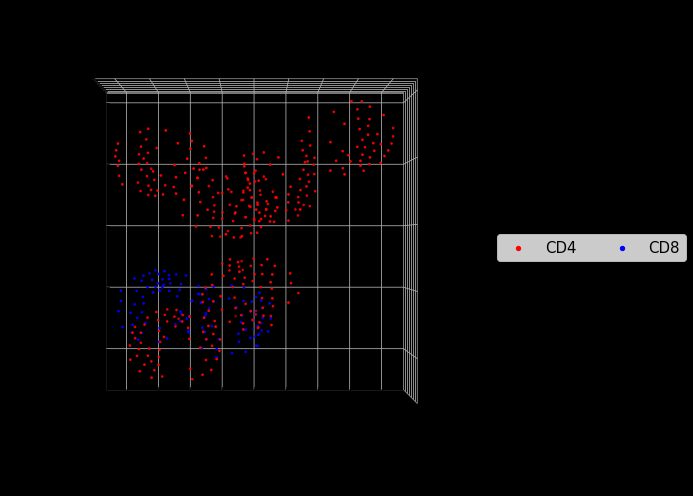

In [60]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(cd4_008_centers['row']*scale,cd4_008_centers['col']*scale,cd4_008_centers['z']*z_scale,'.',color='r',s=3,label='CD4')
ax.scatter(cd8_008_centers['row']*scale,cd8_008_centers['col']*scale,cd8_008_centers['z']*z_scale,'.',color='b',s=3,label='CD8')
ax.view_init(90, 90)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'.\figures\008 patch centers.png',dpi=300)

In [52]:
ref_fov = '010'
df_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_df\cd4'
df_l = os.listdir(df_dir)
df_l.sort()

cd4_dfs = []
for item in df_l:
    fov = item.split('_')[0]
    if fov == ref_fov:
        cd4_dfs.append(pd.read_csv(os.path.join(df_dir,item),index_col=0))

df_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\patched_cell_df\cd8'
df_l = os.listdir(df_dir)
df_l.sort()

cd8_dfs = []
for item in df_l:
    fov = item.split('_')[0]
    if fov == ref_fov:
        cd8_dfs.append(pd.read_csv(os.path.join(df_dir,item),index_col=0))
cd4_dfs = pd.concat(cd4_dfs)
cd8_dfs = pd.concat(cd8_dfs)

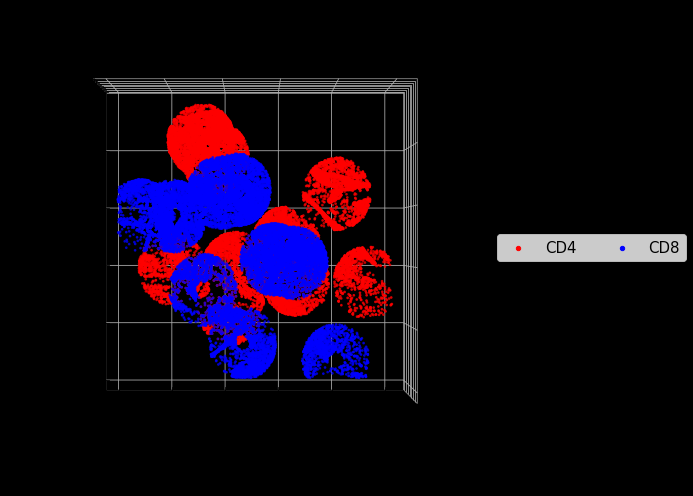

In [53]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(cd4_dfs['row']*scale,cd4_dfs['col']*scale,cd4_dfs['z']*z_scale,'.',color='r',s=3,label='CD4')
ax.scatter(cd8_dfs['row']*scale,cd8_dfs['col']*scale,cd8_dfs['z']*z_scale,'.',color='b',s=3,label='CD8')
ax.view_init(90, 90)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
# plt.savefig(r'.\figures\008_3_scatter dots.png',dpi=300)

In [54]:
cd4_patch_centers = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd4\set1_centers.csv',index_col=0)
cd8_patch_centers = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd8\set1_centers.csv',index_col=0)

cd4_fov = []
for item in cd4_patch_centers['cellID'].tolist():
    cd4_fov.append(item.split('_')[0])
cd4_patch_centers['fov'] = cd4_fov

cd8_fov = []
for item in cd8_patch_centers['cellID'].tolist():
    cd8_fov.append(item.split('_')[0])
cd8_patch_centers['fov'] = cd8_fov

cd4_008_centers = cd4_patch_centers[cd4_patch_centers['fov'] == ref_fov]
cd8_008_centers = cd8_patch_centers[cd8_patch_centers['fov'] == ref_fov]

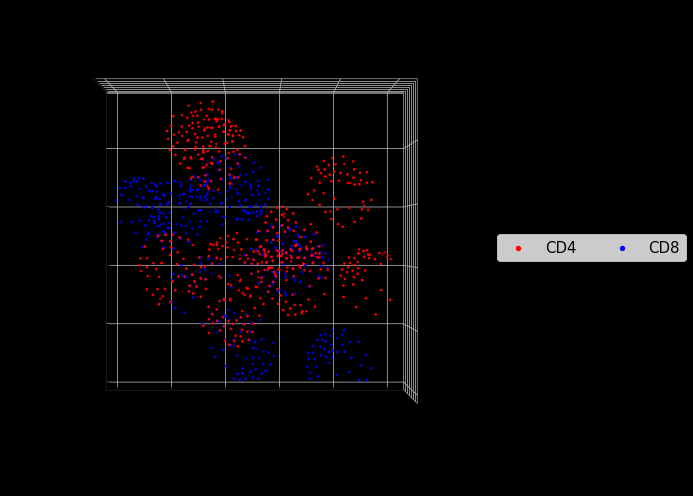

In [56]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
ax.scatter(cd4_008_centers['row']*scale,cd4_008_centers['col']*scale,cd4_008_centers['z']*z_scale,'.',color='r',s=3,label='CD4')
ax.scatter(cd8_008_centers['row']*scale,cd8_008_centers['col']*scale,cd8_008_centers['z']*z_scale,'.',color='b',s=3,label='CD8')
ax.view_init(90, 90)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'.\figures\010 patch centers.png',dpi=300)

# average patch size

In [67]:
patch_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\patched_cell_df\cd4'
patch_l = os.listdir(patch_dir)
patch_l.sort()

idx = np.random.randint(0,len(patch_l), 10)
df_l = []
for i in idx:
    df_l.append(pd.read_csv(os.path.join(patch_dir, patch_l[i]), index_col=0))

In [71]:
for item in df_l:
    print(item['leiden'].value_counts().mean())

74.65079365079364
73.87096774193549
36.125
26.68421052631579
52.83673469387755
42.111111111111114
22.035714285714285
32.02325581395349
39.79245283018868
39.089285714285715
